In [5]:
## Cargar packages
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

import h5py
from mpl_toolkits.mplot3d import Axes3D
import scipy.io

In [71]:
areanames = ['A1', 'Belt', 'PT', 'A7', 'SMA', 'M1']
# Colores RGB
colores = [
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.0000, 0.4470, 0.7410],
    [0.6353, 0.0784, 0.1843],
    [0.4941, 0.4353, 0.0510]
]

nTIs = 4
nPCs = 5
nAreas = 6
nPermu = 100

# Estructura para guardar las proyecciones
cellarrayProjections = [[None for _ in range(nTIs)] for _ in range(nAreas)]

Claves raíz: ['#refs#', 'all_BehavPos_class', 'all_BehavPos_class_Spk', 'nNeu', 'output']
Neuronas por área: [ 576 1033  820 1134  755   93]
Forma de refs_density: (4, 1134, 6)
Area A1: Sin datos suficientes para graficar.
Area Belt: Sin datos suficientes para graficar.
Area PT: Sin datos suficientes para graficar.
Area A7: Sin datos suficientes para graficar.
Area SMA: Sin datos suficientes para graficar.
Area M1: Sin datos suficientes para graficar.
Calculando CCA (Canonical Correlation)...
Generando Heatmaps...


C:\Users\Admin\AppData\Local\Temp\ipykernel_3856\793868924.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


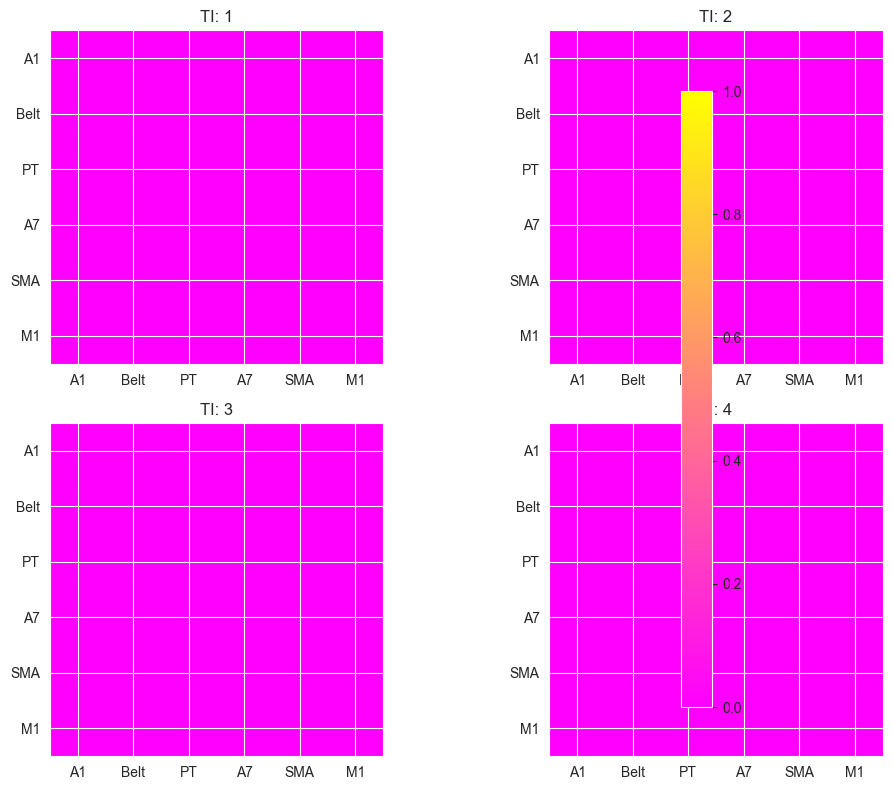

Generando Grafos 2D...


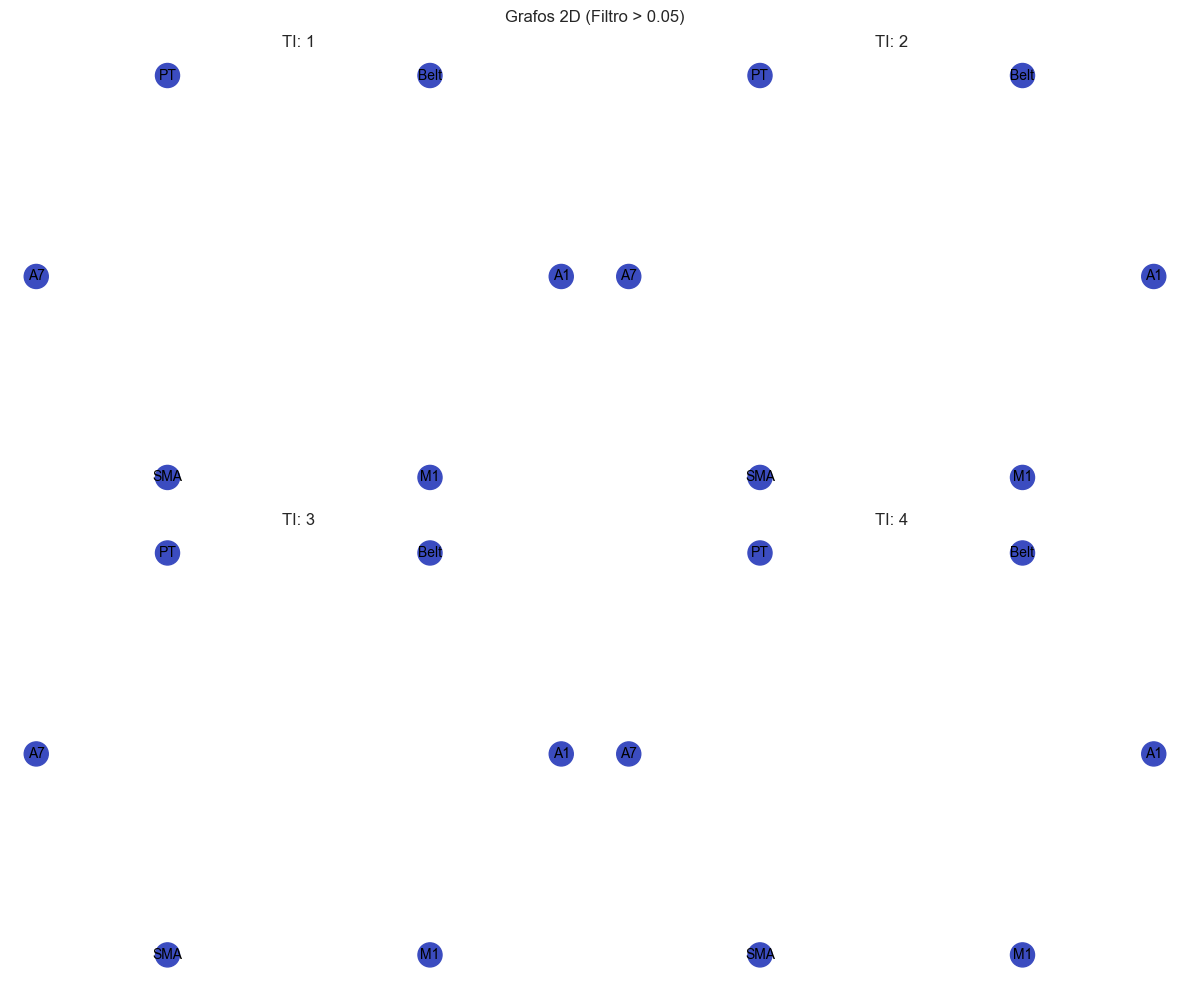

Generando Grafo 3D...


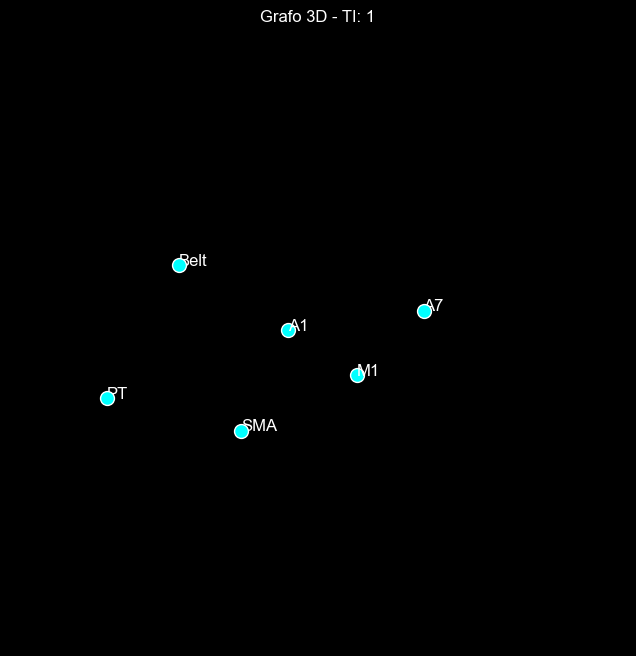

In [76]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import networkx as nx

# Ajusta ruta si es necesario
filename = r"C:\Users\Admin\Desktop\XimLey\labB15\Monkeys_database\Gimena\Tomas_MergeFinal_Pop.mat"


def leer_celda_final(f, ref):
    try:
        obj = f[ref]
        data = np.array(obj)

        if data.size > 0 and data.dtype == 'object':
            flat_data = data.flatten()
            if isinstance(flat_data[0], h5py.h5r.Reference):

                obj_inner = f[flat_data[0]]
                data = np.array(obj_inner)

        if data.size == 0:
            return None

        return data.astype(float)

    except Exception as e:
        # print(f"Error leyendo celda: {e}") # Descomentar para depurar
        return None


with h5py.File(filename, 'r') as f:
    print("Claves raíz:", list(f.keys()))

    try:
        grupo_struct = f['all_BehavPos_class_Spk']
    except KeyError:
        print("No se halló 'all_BehavPos_class_Spk', intentando buscar parecidos...")
        keys = list(f.keys())
        grupo_struct = f[keys[0]]

    refs_density = grupo_struct['Density_abs'][:]

    nNeu_raw = f['nNeu'][:]
    nNeu = nNeu_raw.flatten().astype(int)
    print(f"Neuronas por área: {nNeu}")

    shape = refs_density.shape
    print(f"Forma de refs_density: {shape}")

    for idxArea in range(nAreas):

        current_nNeu = int(nNeu[idxArea])
        if current_nNeu == 0: continue

        fig, axes = plt.subplots(nPCs, 1, figsize=(6, 10), sharex=True)
        fig.suptitle(f'Trayectorias Área: {areanames[idxArea]}')

        datos_graficados = False

        for idxTI in range(nTIs):

            list_den_abs = []

            for idxNeu in range(current_nNeu):
                try:
                    # Opción A: [Area][Neurona][TI]
                    ref_celda = refs_density[idxArea][idxNeu][idxTI]
                except IndexError:
                    try:
                        # Opción B: [Area][TI][Neurona]
                        ref_celda = refs_density[idxArea][idxTI][idxNeu]
                    except IndexError:
                        # Opción C: [TI][Neurona][Area]
                        ref_celda = refs_density[idxTI][idxNeu][idxArea]

                data_row = leer_celda_final(f, ref_celda)

                if data_row is not None:
                    list_den_abs.append(data_row.flatten())

            allDenAbs = np.array(list_den_abs)

            if allDenAbs.shape[0] == 0:
                continue

            X = allDenAbs.T
            if X.shape[0] < nPCs or X.shape[1] < nPCs:
                continue

            pca = PCA(n_components=nPCs)
            score = pca.fit_transform(X)
            projection = score.T

            # Guardar proyección
            if 'cellarrayProjections' in locals():
                cellarrayProjections[idxArea][idxTI] = projection

            datos_graficados = True

            t_axis = np.arange(projection.shape[1])
            for idxPC in range(nPCs):
                ax = axes[idxPC]
                ax.plot(t_axis, projection[idxPC, :], linewidth=1.5,
                        color=colores[idxTI], label=f'TI {idxTI + 1}')
                ax.set_ylabel(f'PC {idxPC + 1}')
                ax.grid(True)

                if idxPC == 0 and idxTI == nTIs - 1:
                    ax.legend(loc='upper right', fontsize='small')

        axes[-1].set_xlabel('Time')
        plt.tight_layout()

        if datos_graficados:
            plt.show()
        else:
            plt.close()
            print(f"Area {areanames[idxArea]}: Sin datos suficientes para graficar.")

print("Calculando CCA (Canonical Correlation)...")

adjMatrices = np.zeros((nAreas, nAreas, nTIs))

for idxTI in range(nTIs):
    for i in range(nAreas):
        for j in range(i, nAreas):
            if i == j:
                adjMatrices[i, j, idxTI] = 0
            else:
                # Validar que existan datos antes de calcular CCA
                if cellarrayProjections[i][idxTI] is None or cellarrayProjections[j][idxTI] is None:
                    adjMatrices[i, j, idxTI] = 0
                    adjMatrices[j, i, idxTI] = 0
                    continue

                dataArea1 = cellarrayProjections[i][idxTI].T
                dataArea2 = cellarrayProjections[j][idxTI].T

                # CCA requiere misma cantidad de muestras (tiempo)
                min_len = min(dataArea1.shape[0], dataArea2.shape[0])
                dataArea1 = dataArea1[:min_len, :]
                dataArea2 = dataArea2[:min_len, :]

                cca = CCA(n_components=1)

                try:
                    cca.fit(dataArea1, dataArea2)
                    X_c, Y_c = cca.transform(dataArea1, dataArea2)

                    r = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
                    max_r = r
                except Exception as e:
                    max_r = 0

                adjMatrices[i, j, idxTI] = max_r
                adjMatrices[j, i, idxTI] = max_r

print("Generando Heatmaps...")

umbral = 0.05
fig_heat, axes_heat = plt.subplots(2, 2, figsize=(10, 8))  # Ajustar según nTIs (ej. 2x2 para 4 TIs)
fig_heat.canvas.manager.set_window_title('Mapas de Calor de Conectividad')
axes_heat = axes_heat.flatten()

for idxTI in range(min(nTIs, len(axes_heat))):
    ax = axes_heat[idxTI]
    M = adjMatrices[:, :, idxTI]

    im = ax.imshow(M, cmap='spring', vmin=0, vmax=1)
    ax.set_title(f'TI: {idxTI + 1}')

    ax.set_xticks(np.arange(nAreas))
    ax.set_yticks(np.arange(nAreas))
    ax.set_xticklabels(areanames)
    ax.set_yticklabels(areanames)

fig_heat.colorbar(im, ax=axes_heat.ravel().tolist())
plt.tight_layout()
plt.show()

print("Generando Grafos 2D...")

coords3D = np.random.rand(nAreas, 3) * 10

fig_graph, axes_graph = plt.subplots(2, 2, figsize=(12, 10))
fig_graph.suptitle(f'Grafos 2D (Filtro > {umbral})')
axes_graph = axes_graph.flatten()

for idxTI in range(min(nTIs, len(axes_graph))):
    ax = axes_graph[idxTI]

    # 1. Filtrar matriz
    M = adjMatrices[:, :, idxTI].copy()
    M[M < umbral] = 0
    np.fill_diagonal(M, 0)

    # 2. Crear Grafo desde matriz de numpy
    G = nx.from_numpy_array(M)
    mapping = {i: name for i, name in enumerate(areanames)}
    G = nx.relabel_nodes(G, mapping)

    # 3. Métricas
    degrees = dict(G.degree(weight='weight'))
    deg_values = np.array(list(degrees.values()))

    # Hubs
    if np.std(deg_values) > 0:
        isHub = deg_values > (np.mean(deg_values) + np.std(deg_values))
    else:
        isHub = np.array([False] * nAreas)

    # Tamaño de nodos
    minSize, maxSize = 300, 1000
    if deg_values.max() > 0:
        norm_deg = (deg_values - deg_values.min()) / (deg_values.max() - deg_values.min() + 1e-9)
        node_sizes = minSize + (norm_deg * (maxSize - minSize))
    else:
        node_sizes = [minSize] * nAreas

    pos = nx.circular_layout(G)
    node_colors = deg_values

    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                                   node_color=node_colors, cmap='coolwarm', ax=ax)

    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

    edges = G.edges(data=True)
    if len(edges) > 0:
        weights = [d['weight'] * 5 for (u, v, d) in edges]
        nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7, ax=ax)

    hubs = [n for n, hub in zip(G.nodes(), isHub) if hub]
    if hubs:
        # Filtrar tamaños correctos para hubs
        hub_sizes = [node_sizes[i] for i, h in enumerate(isHub) if h]
        nx.draw_networkx_nodes(G, pos, nodelist=hubs, node_shape='p',
                               node_color='red', node_size=hub_sizes,
                               edgecolors='yellow', linewidths=2, ax=ax, label='Hub')

    ax.set_title(f'TI: {idxTI + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Generando Grafo 3D...")

targetTI = 0

fig_3d = plt.figure(figsize=(10, 8), facecolor='black')
ax3d = fig_3d.add_subplot(111, projection='3d', facecolor='black')

M3 = adjMatrices[:, :, targetTI].copy()
M3[M3 < umbral] = 0
np.fill_diagonal(M3, 0)

G3 = nx.from_numpy_array(M3)

for i in range(nAreas):
    ax3d.scatter(coords3D[i, 0], coords3D[i, 1], coords3D[i, 2],
                 c='cyan', s=100, edgecolors='w')
    ax3d.text(coords3D[i, 0], coords3D[i, 1], coords3D[i, 2],
              areanames[i], color='white', fontsize=12)

rows, cols = np.where(M3 > 0)
drawn_edges = set()

for r, c in zip(rows, cols):
    if (r, c) not in drawn_edges and (c, r) not in drawn_edges:
        weight = M3[r, c]
        x = [coords3D[r, 0], coords3D[c, 0]]
        y = [coords3D[r, 1], coords3D[c, 1]]
        z = [coords3D[r, 2], coords3D[c, 2]]

        ax3d.plot(x, y, z, c='yellow', linewidth=weight * 3, alpha=0.8)
        drawn_edges.add((r, c))

ax3d.set_title(f'Grafo 3D - TI: {targetTI + 1}', color='white')
ax3d.grid(False)
ax3d.set_axis_off()

plt.show()